In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

Mạng VGG 16

In [ ]:
# import the necessary packages
import os
# define the base path to the input dataset and then use it to derive
# the path to the images directory and annotation CSV file
BASE_PATH = "/content/drive/MyDrive/dataset"
IMAGES_PATH = os.path.sep.join([BASE_PATH, "img"])
ANNOTS_PATH = os.path.sep.join([BASE_PATH, "labels_head_ct_lb.csv"])

In [ ]:
# Define the path to the base output directory
BASE_OUTPUT = "/content/drive/MyDrive/dataset/output"

# Define the path to the output model, label binarizer, plots output directory, and testing image paths
MODEL_PATH = os.path.sep.join([BASE_OUTPUT, "Vgg16_detector.h5"])
LB_PATH = os.path.sep.join([BASE_OUTPUT, "Vgg16_lb.pickle"])
PLOTS_PATH = os.path.sep.join([BASE_OUTPUT, "Vgg16_plots"])
TEST_PATHS = os.path.sep.join([BASE_OUTPUT, "Vgg16_test_images.txt"])

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.layers import Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import pandas as pd
import csv
import pickle

In [ ]:

# initialize our initial learning rate, number of epochs to train
# for, and the batch size
INIT_LR = 1e-4
NUM_EPOCHS = 250
BATCH_SIZE = 16

In [ ]:
# load the contents of the CSV annotations file
print("[INFO] loading dataset...")
rows = open(ANNOTS_PATH).read().strip().split("\n")

# create a DataFrame from the rows
df = pd.DataFrame([row.split(",") for row in rows], columns=["filename", "startX", "startY", "endX", "endY", "label"])


# initialize the list of data (images), our target output predictions
# (bounding box coordinates), along with the filenames and labels
# of the individual images
data = []
targets = []
filenames = []
labels = []

with open(ANNOTS_PATH, 'r') as file:
    reader = csv.reader(file)
    next(reader)  # Skip the header row
    for row in reader:
        filename, startX, startY, endX, endY, label = row

        # Derive the path to the input image
        imagePath = os.path.join(IMAGES_PATH, filename)

        # Load the image (in OpenCV format)
        image = cv2.imread(imagePath)

        if image is None:
            print(f"Error loading image: {imagePath}")
            continue

        (h, w) = image.shape[:2]

        # Scale the bounding box coordinates relative to the spatial
        # dimensions of the input image
        startX = float(startX) / w
        startY = float(startY) / h
        endX = float(endX) / w
        endY = float(endY) / h

        # Load the image and preprocess it
        image = load_img(imagePath, target_size=(224, 224))
        image = img_to_array(image)

        # Update the lists of data, targets, filenames, and labels
        data.append(image)
        targets.append((startX, startY, endX, endY))
        filenames.append(filename)
        labels.append(label)

[INFO] loading dataset...


In [ ]:
unique_labels = np.unique(labels)
print("Number of unique labels:", len(unique_labels))
print("Unique labels:", unique_labels)

Number of unique labels: 2
Unique labels: ['Hemorrhage' 'No-Hemorrhage']


In [ ]:
bboxes = np.array(targets)
imagePaths = np.array(filenames)

In [ ]:
# convert the data, class labels, bounding boxes, and image paths to
# NumPy arrays, scaling the input pixel intensities from the range
# [0, 255] to [0, 1]
data = np.array(data, dtype="float32") / 255.0
labels = np.array(labels)
bboxes = np.array(bboxes, dtype="float32")
imagePaths = np.array(imagePaths)
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
# only there are only two labels in the dataset, then we need to use
# Keras/TensorFlow's utility function as well
if len(lb.classes_) == 2:
	labels = to_categorical(labels)

In [ ]:
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
split = train_test_split(data, labels, bboxes, imagePaths,
	test_size=0.20, random_state=42)
# unpack the data split
(trainImages, testImages) = split[:2]
(trainLabels, testLabels) = split[2:4]
(trainBBoxes, testBBoxes) = split[4:6]
(trainPaths, testPaths) = split[6:]
# write the testing image paths to disk so that we can use then
# when evaluating/testing our object detector
print("[INFO] saving testing image paths...")
f = open(TEST_PATHS, "w")
f.write("\n".join(testPaths))
f.close()

[INFO] saving testing image paths...


In [ ]:
# load the VGG16 network, ensuring the head FC layers are left off
vgg = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))
# freeze all VGG layers so they will *not* be updated during the
# training process
vgg.trainable = False
# flatten the max-pooling output of VGG
flatten = vgg.output
flatten = Flatten()(flatten)

In [ ]:
# construct a fully-connected layer header to output the predicted
# bounding box coordinates
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid",
	name="bounding_box")(bboxHead)
# construct a second fully-connected layer head, this one to predict
# the class label
softmaxHead = Dense(512, activation="relu")(flatten)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(512, activation="relu")(softmaxHead)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(len(lb.classes_), activation="softmax",
	name="class_label")(softmaxHead)
# put together our model which accept an input image and then output
# bounding box coordinates and a class label
model = Model(
	inputs=vgg.input,
	outputs=(bboxHead, softmaxHead))

In [ ]:
# define a dictionary to set the loss methods -- categorical
# cross-entropy for the class label head and mean absolute error
# for the bounding box head
losses = {
	"class_label": "categorical_crossentropy",
	"bounding_box": "mean_squared_error",
}
# define a dictionary that specifies the weights per loss (both the
# class label and bounding box outputs will receive equal weight)
lossWeights = {
	"class_label": 1.0,
	"bounding_box": 1.0
}
# initialize the optimizer, compile the model, and show the model
# summary
opt = Adam(lr=INIT_LR)
model.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=lossWeights)
print(model.summary())

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 224, 224, 64)         1792      ['input_6[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 224, 224, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)         0         ['block1_conv2[0][0]']        
                                                                                            

In [ ]:
# construct a dictionary for our target training outputs
trainTargets = {
	"class_label": trainLabels,
	"bounding_box": trainBBoxes
}
# construct a second dictionary, this one for our target testing
# outputs
testTargets = {
	"class_label": testLabels,
	"bounding_box": testBBoxes
}

In [ ]:

 # train the network for bounding box regression and class label
# prediction
print("[INFO] training model...")
H = model.fit(
	trainImages, trainTargets,
	validation_data=(testImages, testTargets),
	batch_size=BATCH_SIZE,
	epochs=NUM_EPOCHS,
	verbose=1)
# serialize the model to disk
print("[INFO] saving object detector model...")
model.save(MODEL_PATH, save_format="h5")
# serialize the label binarizer to disk
print("[INFO] saving label binarizer...")
f = open(LB_PATH, "wb")
f.write(pickle.dumps(lb))
f.close()

[INFO] training model...
Epoch 1/250
43/43 [==============================] - 7s 106ms/step - loss: 2.9874 - bounding_box_loss: 0.0712 - class_label_loss: 2.9162 - bounding_box_accuracy: 0.5219 - class_label_accuracy: 0.5673 - val_loss: 0.3614 - val_bounding_box_loss: 0.0719 - val_class_label_loss: 0.2896 - val_bounding_box_accuracy: 0.5380 - val_class_label_accuracy: 0.8713
Epoch 2/250
43/43 [==============================] - 4s 104ms/step - loss: 0.6807 - bounding_box_loss: 0.0668 - class_label_loss: 0.6138 - bounding_box_accuracy: 0.5205 - class_label_accuracy: 0.7836 - val_loss: 0.2550 - val_bounding_box_loss: 0.0695 - val_class_label_loss: 0.1855 - val_bounding_box_accuracy: 0.5380 - val_class_label_accuracy: 0.9591
Epoch 3/250
43/43 [==============================] - 4s 102ms/step - loss: 0.2788 - bounding_box_loss: 0.0642 - class_label_loss: 0.2146 - bounding_box_accuracy: 0.5205 - class_label_accuracy: 0.9094 - val_loss: 0.5008 - val_bounding_box_loss: 0.0694 - val_class_label_

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


[INFO] saving label binarizer...


In [ ]:
# Calculate average training and validation loss and accuracy
avg_train_loss = np.mean(H.history["loss"])
avg_train_accuracy = np.mean(H.history["class_label_accuracy"])
avg_val_loss = np.mean(H.history["val_loss"])
avg_val_accuracy = np.mean(H.history["val_class_label_accuracy"])

# Print average values
print("\n[INFO] Average Training Loss:", avg_train_loss)
print("[INFO] Average Training Accuracy:", avg_train_accuracy)
print("\n[INFO] Average Validation Loss:", avg_val_loss)
print("[INFO] Average Validation Accuracy:", avg_val_accuracy)



[INFO] Average Training Loss: 0.27636468946933745
[INFO] Average Training Accuracy: 0.8414795320034028

[INFO] Average Validation Loss: 0.17466134351491927
[INFO] Average Validation Accuracy: 0.9796491327285767


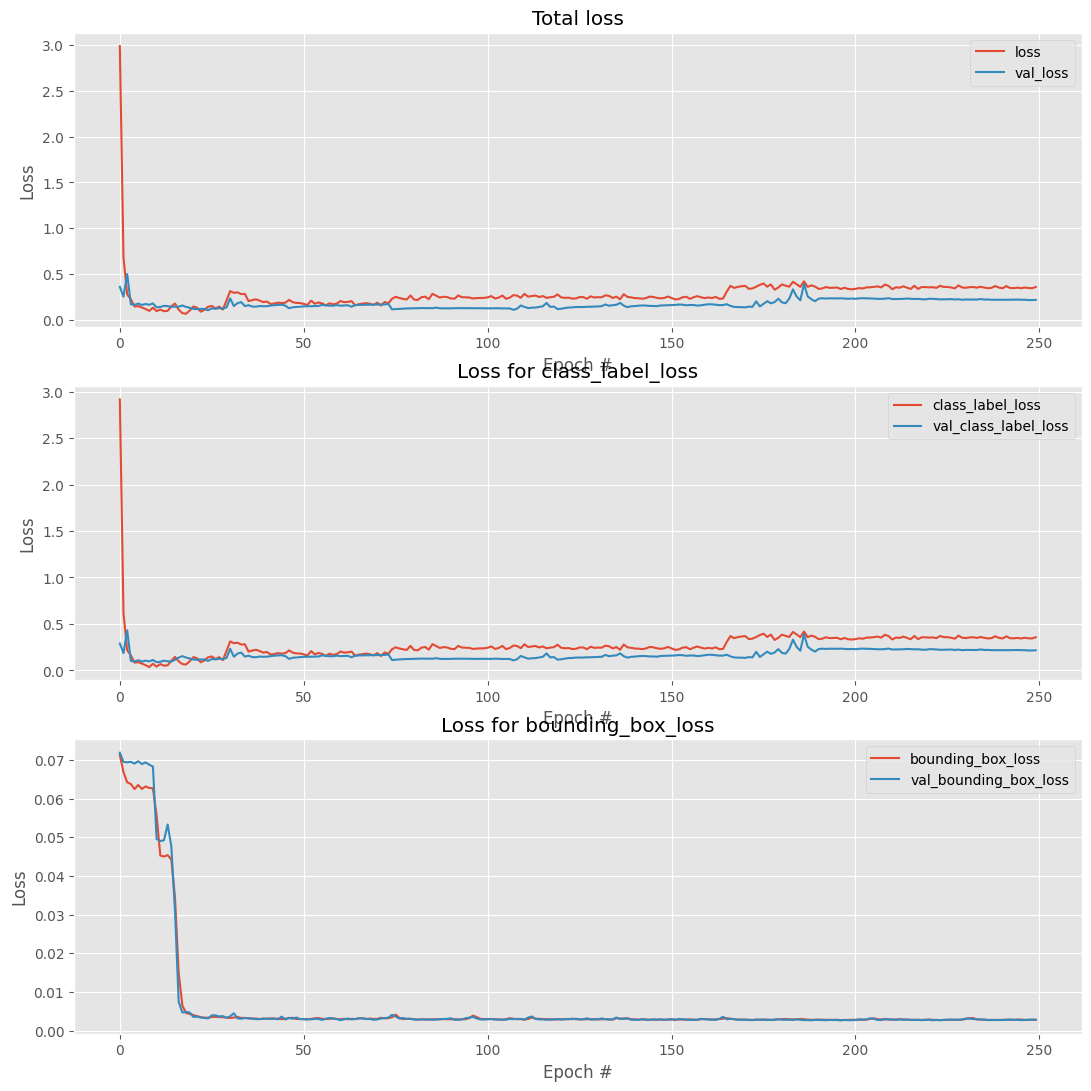

In [ ]:
# plot the total loss, label loss, and bounding box loss
lossNames = ["loss", "class_label_loss", "bounding_box_loss"]
N = np.arange(0, NUM_EPOCHS)
plt.style.use("ggplot")
(fig, ax) = plt.subplots(3, 1, figsize=(13, 13))
# loop over the loss names
for (i, l) in enumerate(lossNames):
	# plot the loss for both the training and validation data
	title = "Loss for {}".format(l) if l != "loss" else "Total loss"
	ax[i].set_title(title)
	ax[i].set_xlabel("Epoch #")
	ax[i].set_ylabel("Loss")
	ax[i].plot(N, H.history[l], label=l)
	ax[i].plot(N, H.history["val_" + l], label="val_" + l)
	ax[i].legend()
# save the losses figure and create a new figure for the accuracies
# plt.tight_layout()
# PLOTS_PATH = os.path.dirname(PLOTS_PATH)
# plotPath = os.path.sep.join([PLOTS_PATH, "lossesVGG16.png"])
# plt.savefig(plotPath)

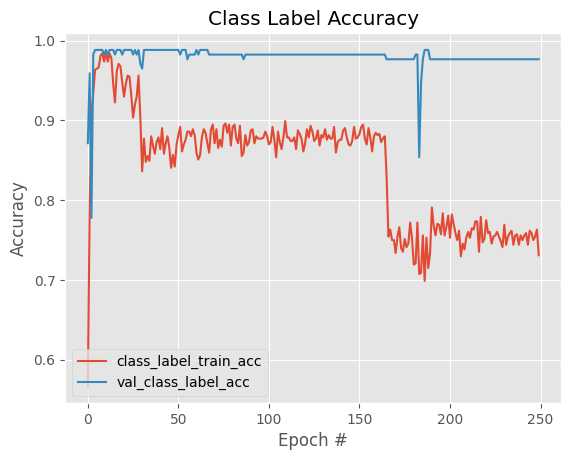

In [ ]:
# create a new figure for the accuracies
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["class_label_accuracy"],
	label="class_label_train_acc")
plt.plot(N, H.history["val_class_label_accuracy"],
	label="val_class_label_acc")
plt.title("Class Label Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
# save the accuracies plot
# plotPath = os.path.sep.join([PLOTS_PATH, "accsVGG16.png"])
# plt.savefig(plotPath)

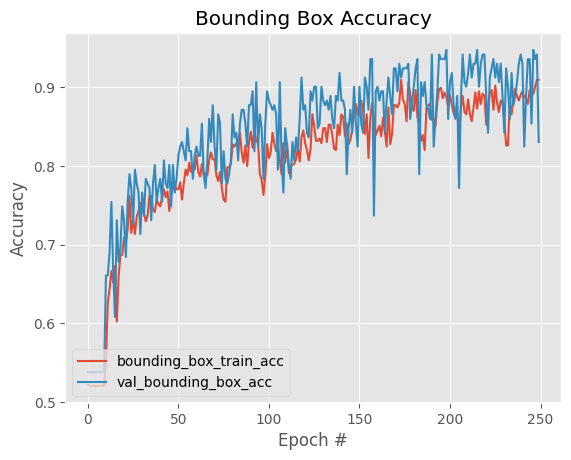

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["bounding_box_accuracy"],
    label="bounding_box_train_acc")
plt.plot(N, H.history["val_bounding_box_accuracy"],
    label="val_bounding_box_acc")
plt.title("Bounding Box Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")

In [ ]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model
import numpy as np
import mimetypes
import argparse
import imutils
import pickle
import cv2
import os
from google.colab.patches import cv2_imshow

In [ ]:
# determine the input file type, but assume that we're working with
# single input image/c
filetype = mimetypes.guess_type("/content/drive/MyDrive/dataset/img/401.png")[0]
imagePaths = ["/content/drive/MyDrive/dataset/img/401.png"]
# if the file type is a text file, then we need to process *multiple*
# images
if "text/plain" == filetype:
	# load the image paths in our testing file
	imagePaths = open("/content/drive/MyDrive/dataset/img/401.png".read().strip().split("\n"))

In [ ]:
# load our object detector and label binarizer from disk
print("[INFO] loading object detector...")
model = load_model(MODEL_PATH)
lb = pickle.loads(open(LB_PATH, "rb").read())

[INFO] loading object detector...


1/1 [==============================] - 2s 2s/step


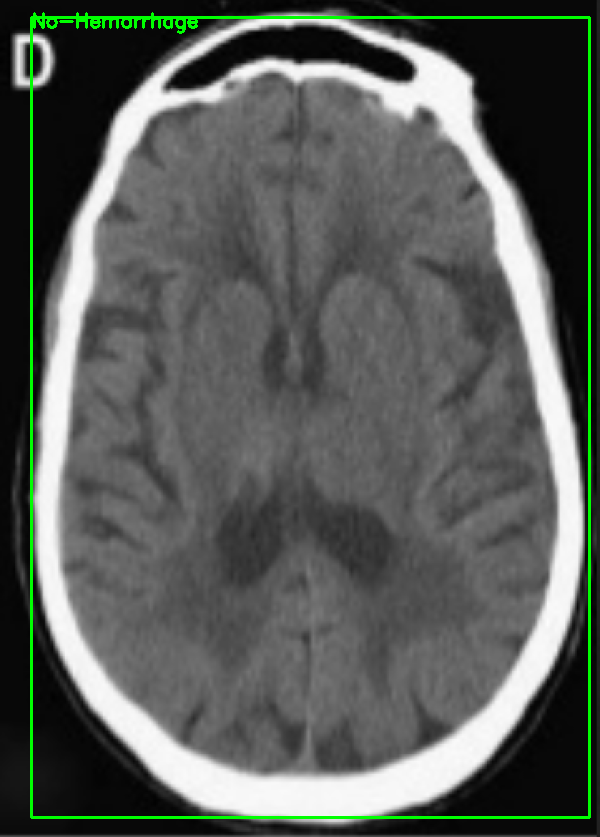

In [ ]:
 # loop over the images that we'll be testing using our bounding box
# regression model
for imagePath in imagePaths:
	# load the input image (in Keras format) from disk and preprocess
	# it, scaling the pixel intensities to the range [0, 1]
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image) / 255.0
	image = np.expand_dims(image, axis=0)
	# predict the bounding box of the object along with the class
	# label
	(boxPreds, labelPreds) = model.predict(image)
	(startX, startY, endX, endY) = boxPreds[0]
	# determine the class label with the largest predicted
	# probability
	i = np.argmax(labelPreds, axis=1)
	label = lb.classes_[i][0]
	# load the input image (in OpenCV format), resize it such that it
	# fits on our screen, and grab its dimensions
	image = cv2.imread(imagePath)
	image = imutils.resize(image, width=600)
	(h, w) = image.shape[:2]
	# scale the predicted bounding box coordinates based on the image
	# dimensions
	startX = int(startX * w)
	startY = int(startY * h)
	endX = int(endX * w)
	endY = int(endY * h)
	# draw the predicted bounding box and class label on the image
	y = startY - 10 if startY - 10 > 10 else startY + 10
	cv2.putText(image, label, (startX, y), cv2.FONT_HERSHEY_SIMPLEX,
		0.65, (0, 255, 0), 2)
	cv2.rectangle(image, (startX, startY), (endX, endY),
		(0, 255, 0), 2)
	# show the output image
	cv2_imshow(image)
	cv2.waitKey(0)

Mạng Resnet 50V2

In [ ]:
# import the necessary packages
import os
# define the base path to the input dataset and then use it to derive
# the path to the images directory and annotation CSV file
BASE_PATH = "/content/drive/MyDrive/dataset"
IMAGES_PATH = os.path.sep.join([BASE_PATH, "img"])
ANNOTS_PATH= os.path.sep.join([BASE_PATH, "labels_head_ct_lb.csv"])

In [ ]:
# Define the path to the base output directory
BASE_OUTPUT = "/content/drive/MyDrive/dataset/output"

# Define the path to the output model, label binarizer, plots output directory, and testing image paths
MODEL_PATH_ResNet50V2 = os.path.sep.join([BASE_OUTPUT, "ResNet50v2_detector.h5"])
LB_PATH_ResNet50V2 = os.path.sep.join([BASE_OUTPUT, "ResNet50v2_lb.pickle"])
PLOTS_PATH_ResNet50V2 = os.path.sep.join([BASE_OUTPUT, "ResNet50v2_plots"])
TEST_PATHS_ResNet50V2 = os.path.sep.join([BASE_OUTPUT, "ResNet50v2_test_images.txt"])

In [ ]:

from tensorflow.keras.applications import ResNet50V2
from keras.layers import concatenate
from tensorflow.keras.layers import Add
from keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.layers import Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import pandas as pd
import csv
import pickle




In [ ]:

# initialize our initial learning rate, number of epochs to train
# for, and the batch size
INIT_LR = 1e-4
NUM_EPOCHS = 250
BATCH_SIZE = 16

In [ ]:
# load the contents of the CSV annotations file
print("[INFO] loading dataset...")
rows = open(ANNOTS_PATH).read().strip().split("\n")

# create a DataFrame from the rows
df = pd.DataFrame([row.split(",") for row in rows], columns=["filename", "startX", "startY", "endX", "endY", "label"])


# initialize the list of data (images), our target output predictions
# (bounding box coordinates), along with the filenames and labels
# of the individual images
data = []
targets = []
filenames = []
labels = []

with open(ANNOTS_PATH, 'r') as file:
    reader = csv.reader(file)
    next(reader)  # Skip the header row
    for row in reader:
        filename, startX, startY, endX, endY, label = row

        # Derive the path to the input image
        imagePath = os.path.join(IMAGES_PATH, filename)

        # Load the image (in OpenCV format)
        image = cv2.imread(imagePath)

        if image is None:
            print(f"Error loading image: {imagePath}")
            continue

        (h, w) = image.shape[:2]

        # Scale the bounding box coordinates relative to the spatial
        # dimensions of the input image
        startX = float(startX) / w
        startY = float(startY) / h
        endX = float(endX) / w
        endY = float(endY) / h

        # Load the image and preprocess it
        image = load_img(imagePath, target_size=(224, 224))
        image = img_to_array(image)

        # Update the lists of data, targets, filenames, and labels
        data.append(image)
        targets.append((startX, startY, endX, endY))
        filenames.append(filename)
        labels.append(label)

[INFO] loading dataset...


In [ ]:
unique_labels = np.unique(labels)
print("Number of unique labels:", len(unique_labels))
print("Unique labels:", unique_labels)

Number of unique labels: 2
Unique labels: ['Hemorrhage' 'No-Hemorrhage']


In [ ]:
bboxes = np.array(targets)
imagePaths = np.array(filenames)

In [ ]:
# convert the data, class labels, bounding boxes, and image paths to
# NumPy arrays, scaling the input pixel intensities from the range
# [0, 255] to [0, 1]
data = np.array(data, dtype="float32") / 255.0
labels = np.array(labels)
bboxes = np.array(bboxes, dtype="float32")
imagePaths = np.array(imagePaths)
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
# only there are only two labels in the dataset, then we need to use
# Keras/TensorFlow's utility function as well
if len(lb.classes_) == 2:
	labels = to_categorical(labels)

In [ ]:
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
split = train_test_split(data, labels, bboxes, imagePaths,
	test_size=0.20, random_state=42)
# unpack the data split
(trainImages, testImages) = split[:2]
(trainLabels, testLabels) = split[2:4]
(trainBBoxes, testBBoxes) = split[4:6]
(trainPaths, testPaths) = split[6:]
# write the testing image paths to disk so that we can use then
# when evaluating/testing our object detector
print("[INFO] saving testing image paths...")
f = open(TEST_PATHS_ResNet50V2, "w")
f.write("\n".join(testPaths))
f.close()

[INFO] saving testing image paths...


In [ ]:
# load the resnet16 network, ensuring the head FC layers are left off
resnet = ResNet50V2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))
# freeze all resnet layers so they will *not* be updated during the
# training process
resnet.trainable = True
# flatten the max-pooling output of resnet
flatten = resnet.output
flatten = Flatten()(flatten)

94668760/94668760 [==============================] - 1s 0us/step


In [ ]:
# construct a fully-connected layer header to output the predicted
# bounding box coordinates
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid",
	name="bounding_box")(bboxHead)
# construct a second fully-connected layer head, this one to predict
# the class label
softmaxHead = Dense(512, activation="relu")(flatten)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(512, activation="relu")(softmaxHead)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(len(lb.classes_), activation="softmax",
	name="class_label")(softmaxHead)
# put together our model which accept an input image and then output
# bounding box coordinates and a class label
model = Model(
	inputs=resnet.input,
	outputs=(bboxHead, softmaxHead))

In [ ]:
# define a dictionary to set the loss methods -- categorical
# cross-entropy for the class label head and mean absolute error
# for the bounding box head
losses = {
	"class_label": "categorical_crossentropy",
	"bounding_box": "mean_squared_error",
}
# define a dictionary that specifies the weights per loss (both the
# class label and bounding box outputs will receive equal weight)
lossWeights = {
	"class_label": 1.0,
	"bounding_box": 1.0
}
# initialize the optimizer, compile the model, and show the model
# summary
opt = Adam(lr=INIT_LR)
model.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=lossWeights)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                              

In [ ]:
# construct a dictionary for our target training outputs
trainTargets = {
	"class_label": trainLabels,
	"bounding_box": trainBBoxes
}
# construct a second dictionary, this one for our target testing
# outputs
testTargets = {
	"class_label": testLabels,
	"bounding_box": testBBoxes
}

In [ ]:
 import time
 start_time = time.time()
 # train the network for bounding box regression and class label
# prediction
print("[INFO] training model...")
H = model.fit(
	trainImages, trainTargets,
	validation_data=(testImages, testTargets),
	batch_size=BATCH_SIZE,
	epochs=NUM_EPOCHS,
	verbose=1)
# Record the end time
end_time = time.time()
# Calculate the training time
training_time = end_time - start_time
# serialize the model to disk
print("[INFO] saving object detector model...")
model.save(MODEL_PATH_ResNet50V2, save_format="h5")
# serialize the label binarizer to disk
print("[INFO] saving label binarizer...")
f = open(LB_PATH_ResNet50V2, "wb")
f.write(pickle.dumps(lb))
f.close()

[INFO] training model...
Epoch 1/250
43/43 [==============================] - 56s 313ms/step - loss: 1.6752 - bounding_box_loss: 0.0547 - class_label_loss: 1.6205 - bounding_box_accuracy: 0.5482 - class_label_accuracy: 0.7500 - val_loss: 3264.3896 - val_bounding_box_loss: 0.0917 - val_class_label_loss: 3264.2979 - val_bounding_box_accuracy: 0.4620 - val_class_label_accuracy: 0.5556
Epoch 2/250
43/43 [==============================] - 8s 177ms/step - loss: 1.5436 - bounding_box_loss: 0.0606 - class_label_loss: 1.4830 - bounding_box_accuracy: 0.4722 - class_label_accuracy: 0.6184 - val_loss: 14596030.0000 - val_bounding_box_loss: 0.0917 - val_class_label_loss: 14596030.0000 - val_bounding_box_accuracy: 0.4620 - val_class_label_accuracy: 0.5556
Epoch 3/250
43/43 [==============================] - 8s 182ms/step - loss: 1.2696 - bounding_box_loss: 0.0481 - class_label_loss: 1.2215 - bounding_box_accuracy: 0.5424 - class_label_accuracy: 0.7354 - val_loss: 49.1206 - val_bounding_box_loss: 0.2

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


[INFO] saving label binarizer...


In [ ]:
# Calculate average training and validation loss and accuracy
avg_train_loss = np.mean(H.history["loss"])
avg_train_accuracy = np.mean(H.history["class_label_accuracy"])
avg_val_loss = np.mean(H.history["val_loss"])
avg_val_accuracy = np.mean(H.history["val_class_label_accuracy"])

# Print average values
print("\n[INFO] Average Training Loss:", avg_train_loss)
print("[INFO] Average Training Accuracy:", avg_train_accuracy)
print("\n[INFO] Average Validation Loss:", avg_val_loss)
print("[INFO] Average Validation Accuracy:", avg_val_accuracy)
print("\n[INFO] Training Time:", training_time, "seconds")



[INFO] Average Training Loss: 0.2966549381576479
[INFO] Average Training Accuracy: 0.9453567305803299

[INFO] Average Validation Loss: 650384.2563366713
[INFO] Average Validation Accuracy: 0.9022690035104751

[INFO] Training Time: 2078.1151304244995 seconds


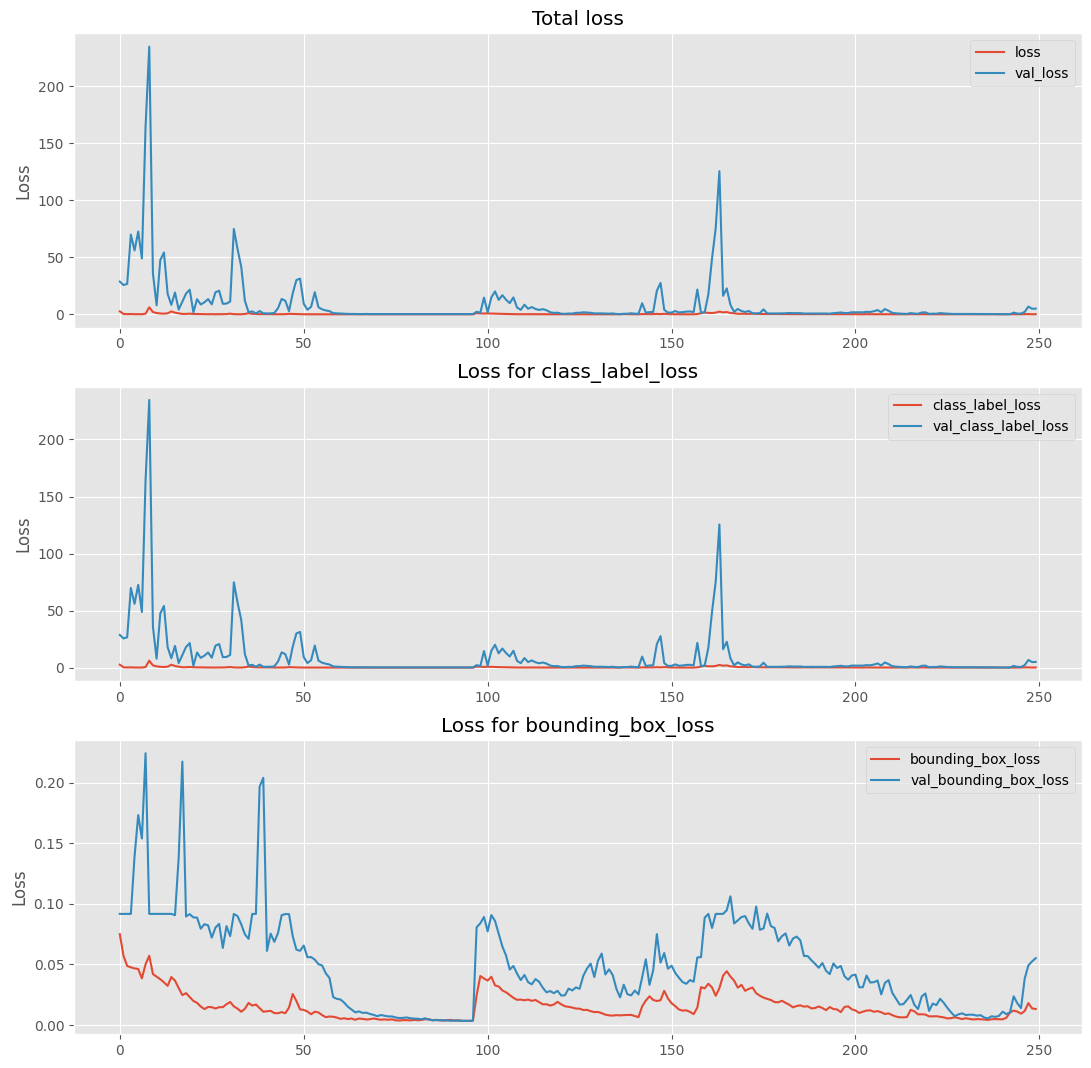

In [ ]:

# plot the total loss, label loss, and bounding box loss
lossNames = ["loss", "class_label_loss", "bounding_box_loss"]
N = np.arange(0, NUM_EPOCHS)
plt.style.use("ggplot")
(fig, ax) = plt.subplots(3, 1, figsize=(13, 13))
# loop over the loss names
for (i, l) in enumerate(lossNames):
	# plot the loss for both the training and validation data
	title = "Loss for {}".format(l) if l != "loss" else "Total loss"
	ax[i].set_title(title)
	# ax[i].set_xlabel("Epoch #")
	ax[i].set_ylabel("Loss")
	ax[i].plot(N, H.history[l], label=l)
	ax[i].plot(N, H.history["val_" + l], label="val_" + l)
	ax[i].legend()
# save the losses figure and create a new figure for the accuracies
# plt.tight_layout()
# PLOTS_PATH_ResNet50V2 = os.path.dirname(PLOTS_PATH_ResNet50V2)
# plotPath = os.path.sep.join([PLOTS_PATH_ResNet50V2, "lossesResnet50V2.png"])
# plt.savefig(plotPath)

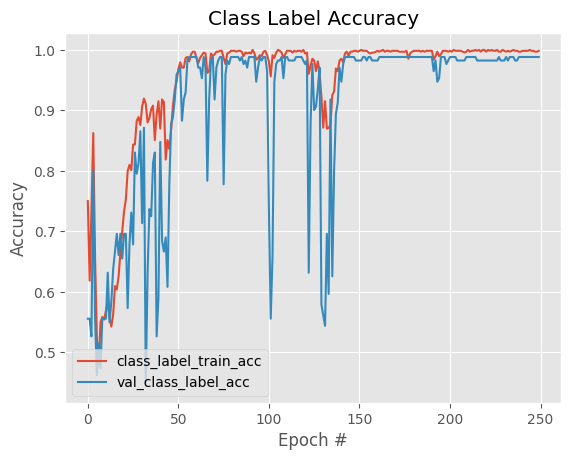

In [ ]:
# create a new figure for the accuracies
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["class_label_accuracy"],
	label="class_label_train_acc")
plt.plot(N, H.history["val_class_label_accuracy"],
	label="val_class_label_acc")
plt.title("Class Label Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
# save the accuracies plot
# plotPath = os.path.sep.join([PLOTS_PATH_ResNet50V2, "accsResnet50V2.png"])
# plt.savefig(plotPath)

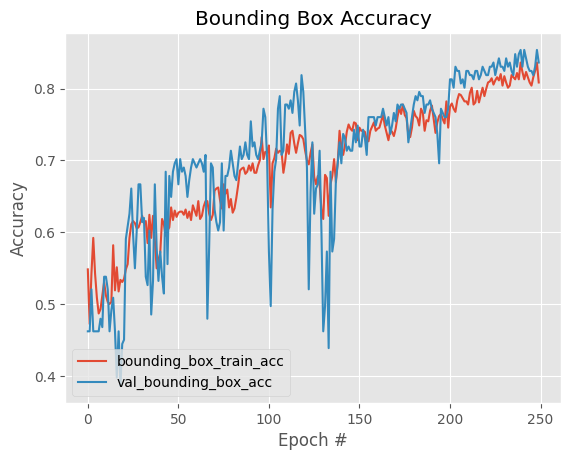

In [ ]:
# Create a new figure for the bounding box accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["bounding_box_accuracy"],
    label="bounding_box_train_acc")
plt.plot(N, H.history["val_bounding_box_accuracy"],
    label="val_bounding_box_acc")
plt.title("Bounding Box Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")

# Save the bounding box accuracy plot
# plotPathBoundingBox = os.path.sep.join([PLOTS_PATH, "accsVGG16_bounding_box.png"])
# plt.savefig(plotPathBoundingBox)

In [ ]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model
import numpy as np
import mimetypes
import argparse
import imutils
import pickle
import cv2
import os
from google.colab.patches import cv2_imshow

In [ ]:
# determine the input file type, but assume that we're working with
# single input image/c
filetype = mimetypes.guess_type("/content/drive/MyDrive/dataset/img/401.png")[0]
imagePaths = ["/content/drive/MyDrive/dataset/img/401.png"]
# if the file type is a text file, then we need to process *multiple*
# images
if "text/plain" == filetype:
	# load the image paths in our testing file
	imagePaths = open("/content/drive/MyDrive/dataset/img/401.png".read().strip().split("\n"))

In [ ]:
# load our object detector and label binarizer from disk
print("[INFO] loading object detector...")
model = load_model(MODEL_PATH_ResNet50V2)
lb = pickle.loads(open(LB_PATH_ResNet50V2, "rb").read())

[INFO] loading object detector...


1/1 [==============================] - 2s 2s/step


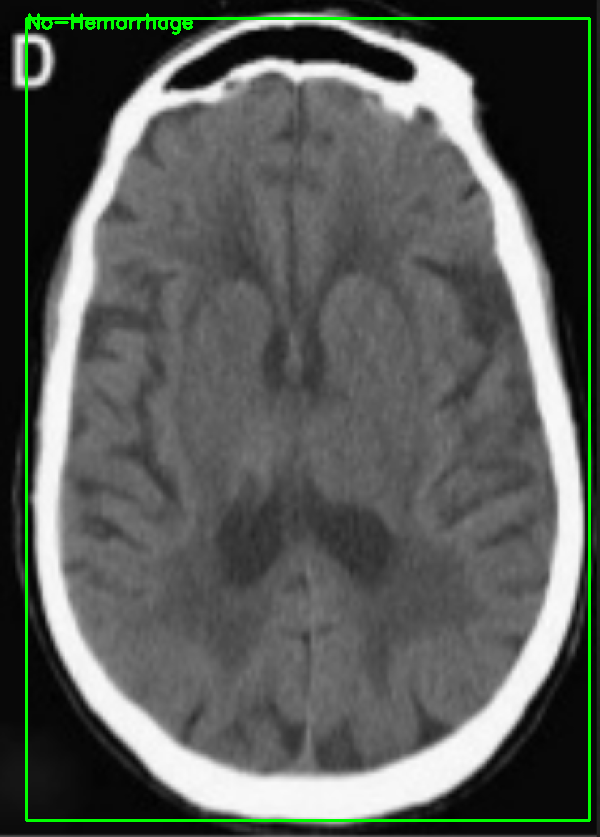

In [ ]:
 # loop over the images that we'll be testing using our bounding box
# regression model
for imagePath in imagePaths:
	# load the input image (in Keras format) from disk and preprocess
	# it, scaling the pixel intensities to the range [0, 1]
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image) / 255.0
	image = np.expand_dims(image, axis=0)
	# predict the bounding box of the object along with the class
	# label
	(boxPreds, labelPreds) = model.predict(image)
	(startX, startY, endX, endY) = boxPreds[0]
	# determine the class label with the largest predicted
	# probability
	i = np.argmax(labelPreds, axis=1)
	label = lb.classes_[i][0]
	# load the input image (in OpenCV format), resize it such that it
	# fits on our screen, and grab its dimensions
	image = cv2.imread(imagePath)
	image = imutils.resize(image, width=600)
	(h, w) = image.shape[:2]
	# scale the predicted bounding box coordinates based on the image
	# dimensions
	startX = int(startX * w)
	startY = int(startY * h)
	endX = int(endX * w)
	endY = int(endY * h)
	# draw the predicted bounding box and class label on the image
	y = startY - 10 if startY - 10 > 10 else startY + 10
	cv2.putText(image, label, (startX, y), cv2.FONT_HERSHEY_SIMPLEX,
		0.65, (0, 255, 0), 2)
	cv2.rectangle(image, (startX, startY), (endX, endY),
		(0, 255, 0), 2)
	# show the output image
	cv2_imshow(image)
	cv2.waitKey(0)

Mạng mobile Net V2


In [ ]:
# import the necessary packages
import os
# define the base path to the input dataset and then use it to derive
# the path to the images directory and annotation CSV file
BASE_PATH = "/content/drive/MyDrive/dataset"
IMAGES_PATH = os.path.sep.join([BASE_PATH, "img"])
ANNOTS_PATH = os.path.sep.join([BASE_PATH, "labels_head_ct_lb.csv"])

In [ ]:
# Define the path to the base output directory
BASE_OUTPUT = "/content/drive/MyDrive/dataset/output"

# Define the path to the output model, label binarizer, plots output directory, and testing image paths
MODEL_PATH_MobileNet_V2 = os.path.sep.join([BASE_OUTPUT, "MobileNet_V2_detector.h5"])
LB_PATH_MobileNet_V2 = os.path.sep.join([BASE_OUTPUT, "MobileNet_V2_lb.pickle"])
PLOTS_PATH_MobileNet_V2 = os.path.sep.join([BASE_OUTPUT, "MobileNet_V2_plots"])
TEST_PATHS_MobileNet_V2 = os.path.sep.join([BASE_OUTPUT, "MobileNet_V2_test_images.txt"])

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.layers import Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import pandas as pd
import csv
import pickle

In [ ]:

# initialize our initial learning rate, number of epochs to train
# for, and the batch size
INIT_LR = 1e-4
NUM_EPOCHS = 250
BATCH_SIZE = 16

In [ ]:
# load the contents of the CSV annotations file
print("[INFO] loading dataset...")
rows = open(ANNOTS_PATH).read().strip().split("\n")

# create a DataFrame from the rows
df = pd.DataFrame([row.split(",") for row in rows], columns=["filename", "startX", "startY", "endX", "endY", "label"])


# initialize the list of data (images), our target output predictions
# (bounding box coordinates), along with the filenames and labels
# of the individual images
data = []
targets = []
filenames = []
labels = []

with open(ANNOTS_PATH, 'r') as file:
    reader = csv.reader(file)
    next(reader)  # Skip the header row
    for row in reader:
        filename, startX, startY, endX, endY, label = row

        # Derive the path to the input image
        imagePath = os.path.join(IMAGES_PATH, filename)

        # Load the image (in OpenCV format)
        image = cv2.imread(imagePath)

        if image is None:
            print(f"Error loading image: {imagePath}")
            continue

        (h, w) = image.shape[:2]

        # Scale the bounding box coordinates relative to the spatial
        # dimensions of the input image
        startX = float(startX) / w
        startY = float(startY) / h
        endX = float(endX) / w
        endY = float(endY) / h

        # Load the image and preprocess it
        image = load_img(imagePath, target_size=(224, 224))
        image = img_to_array(image)

        # Update the lists of data, targets, filenames, and labels
        data.append(image)
        targets.append((startX, startY, endX, endY))
        filenames.append(filename)
        labels.append(label)

[INFO] loading dataset...


In [ ]:
unique_labels = np.unique(labels)
print("Number of unique labels:", len(unique_labels))
print("Unique labels:", unique_labels)

Number of unique labels: 2
Unique labels: ['Hemorrhage' 'No-Hemorrhage']


In [ ]:
bboxes = np.array(targets)
imagePaths = np.array(filenames)

In [ ]:
# convert the data, class labels, bounding boxes, and image paths to
# NumPy arrays, scaling the input pixel intensities from the range
# [0, 255] to [0, 1]
data = np.array(data, dtype="float32") / 255.0
labels = np.array(labels)
bboxes = np.array(bboxes, dtype="float32")
imagePaths = np.array(imagePaths)
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
# only there are only two labels in the dataset, then we need to use
# Keras/TensorFlow's utility function as well
if len(lb.classes_) == 2:
	labels = to_categorical(labels)

In [ ]:
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
split = train_test_split(data, labels, bboxes, imagePaths,
	test_size=0.20, random_state=42)
# unpack the data split
(trainImages, testImages) = split[:2]
(trainLabels, testLabels) = split[2:4]
(trainBBoxes, testBBoxes) = split[4:6]
(trainPaths, testPaths) = split[6:]
# write the testing image paths to disk so that we can use then
# when evaluating/testing our object detector
print("[INFO] saving testing image paths...")
f = open(TEST_PATHS_MobileNet_V2, "w")
f.write("\n".join(testPaths))
f.close()

[INFO] saving testing image paths...


In [ ]:
# load the MobileNet V2 network, ensuring the head FC layers are left off
MobileNet = MobileNetV2(weights="imagenet", include_top=False,
                    input_tensor=Input(shape=(224, 224, 3)))

# freeze all MobileNet layers so they will not be updated during the training process
MobileNet.trainable = True

# flatten the max-pooling output of MobileNet
flatten = MobileNet.output
flatten = Flatten()(flatten)

In [ ]:
# construct a fully-connected layer header to output the predicted bounding box coordinates
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid", name="bounding_box")(bboxHead)

# construct a second fully-connected layer head, this one to predict the class label
softmaxHead = Dense(512, activation="relu")(flatten)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(512, activation="relu")(softmaxHead)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(len(lb.classes_), activation="softmax", name="class_label")(softmaxHead)

# put together our model which accepts an input image and then outputs bounding box coordinates and a class label
model = Model(inputs=MobileNet.input, outputs=(bboxHead, softmaxHead))

In [ ]:
# define a dictionary to set the loss methods -- categorical
# cross-entropy for the class label head and mean absolute error
# for the bounding box head
losses = {
	"class_label": "categorical_crossentropy",
	"bounding_box": "mean_squared_error",
}
# define a dictionary that specifies the weights per loss (both the
# class label and bounding box outputs will receive equal weight)
lossWeights = {
	"class_label": 1.0,
	"bounding_box": 1.0
}
# initialize the optimizer, compile the model, and show the model
# summary
opt = Adam(lr=INIT_LR)
model.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=lossWeights)
print(model.summary())

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_4[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']      

In [ ]:
# construct a dictionary for our target training outputs
trainTargets = {
	"class_label": trainLabels,
	"bounding_box": trainBBoxes
}
# construct a second dictionary, this one for our target testing
# outputs
testTargets = {
	"class_label": testLabels,
	"bounding_box": testBBoxes
}

In [ ]:
import time
start_time = time.time()
 # train the network for bounding box regression and class label
# prediction
print("[INFO] training model...")
H = model.fit(
	trainImages, trainTargets,
	validation_data=(testImages, testTargets),
	batch_size=BATCH_SIZE,
	epochs=NUM_EPOCHS,
	verbose=1)
# Record the end time
end_time = time.time()
# Calculate the training time
training_time = end_time - start_time
# serialize the model to disk
print("[INFO] saving object detector model...")
model.save(MODEL_PATH_MobileNet_V2, save_format="h5")
# serialize the label binarizer to disk
print("[INFO] saving label binarizer...")
f = open(LB_PATH_MobileNet_V2, "wb")
f.write(pickle.dumps(lb))
f.close()

[INFO] training model...
Epoch 1/250
43/43 [==============================] - 28s 131ms/step - loss: 3.4941 - bounding_box_loss: 0.0848 - class_label_loss: 3.4093 - bounding_box_accuracy: 0.4883 - class_label_accuracy: 0.6813 - val_loss: 29.5965 - val_bounding_box_loss: 0.0917 - val_class_label_loss: 29.5047 - val_bounding_box_accuracy: 0.4620 - val_class_label_accuracy: 0.4444
Epoch 2/250
43/43 [==============================] - 4s 97ms/step - loss: 1.0227 - bounding_box_loss: 0.0437 - class_label_loss: 0.9789 - bounding_box_accuracy: 0.6096 - class_label_accuracy: 0.8319 - val_loss: 71.5269 - val_bounding_box_loss: 0.0917 - val_class_label_loss: 71.4352 - val_bounding_box_accuracy: 0.4620 - val_class_label_accuracy: 0.4444
Epoch 3/250
43/43 [==============================] - 4s 92ms/step - loss: 0.8138 - bounding_box_loss: 0.0350 - class_label_loss: 0.7788 - bounding_box_accuracy: 0.6023 - class_label_accuracy: 0.8363 - val_loss: 88.0601 - val_bounding_box_loss: 0.0917 - val_class_la

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


[INFO] saving label binarizer...


In [ ]:
# Calculate average training and validation loss and accuracy
avg_train_loss = np.mean(H.history["loss"])
avg_train_accuracy = np.mean(H.history["class_label_accuracy"])
avg_val_loss = np.mean(H.history["val_loss"])
avg_val_accuracy = np.mean(H.history["val_class_label_accuracy"])

# Print average values
print("\n[INFO] Average Training Loss:", avg_train_loss)
print("[INFO] Average Training Accuracy:", avg_train_accuracy)
print("\n[INFO] Average Validation Loss:", avg_val_loss)
print("[INFO] Average Validation Accuracy:", avg_val_accuracy)
print("\n[INFO] Training Time:", training_time, "seconds")



[INFO] Average Training Loss: 0.31924491391144694
[INFO] Average Training Accuracy: 0.9415614094734192

[INFO] Average Validation Loss: 73.5222892370224
[INFO] Average Validation Accuracy: 0.710643280506134

[INFO] Training Time: 1067.754233121872 seconds


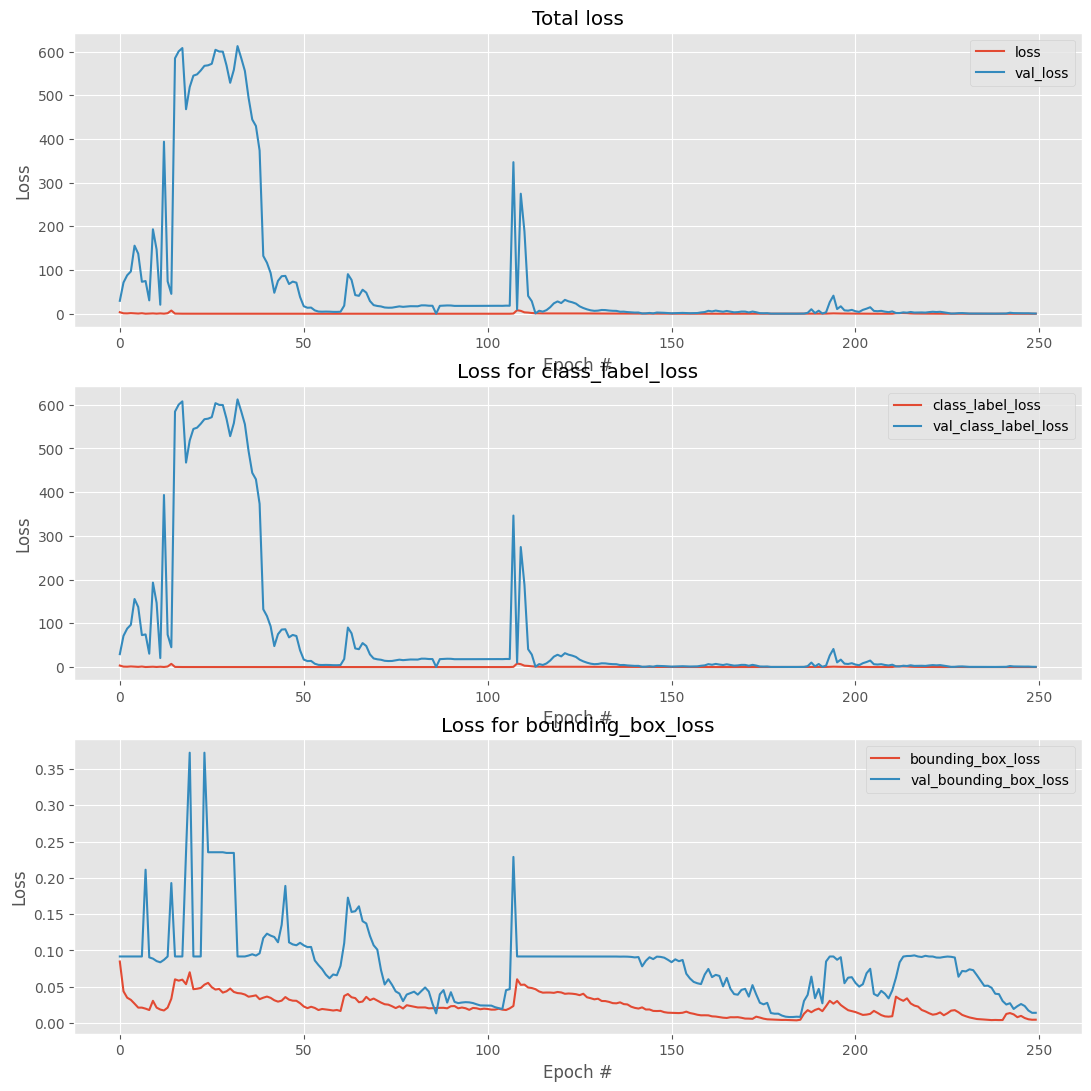

In [ ]:
# plot the total loss, label loss, and bounding box loss
lossNames = ["loss", "class_label_loss", "bounding_box_loss"]
N = np.arange(0, NUM_EPOCHS)
plt.style.use("ggplot")
(fig, ax) = plt.subplots(3, 1, figsize=(13, 13))
# loop over the loss names
for (i, l) in enumerate(lossNames):
	# plot the loss for both the training and validation data
	title = "Loss for {}".format(l) if l != "loss" else "Total loss"
	ax[i].set_title(title)
	ax[i].set_xlabel("Epoch #")
	ax[i].set_ylabel("Loss")
	ax[i].plot(N, H.history[l], label=l)
	ax[i].plot(N, H.history["val_" + l], label="val_" + l)
	ax[i].legend()
# save the losses figure and create a new figure for the accuracies
# plt.tight_layout()
# PLOTS_PATH = os.path.dirname(PLOTS_PATH_MobileNet_V2)
# plotPath = os.path.sep.join([PLOTS_PATH_MobileNet_V2, "lossesMobileNetV2.png"])
# plt.savefig(plotPath)

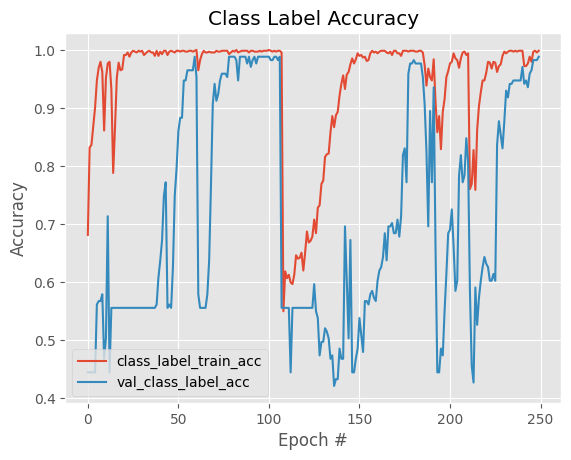

In [ ]:
# create a new figure for the accuracies
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["class_label_accuracy"],
	label="class_label_train_acc")
plt.plot(N, H.history["val_class_label_accuracy"],
	label="val_class_label_acc")
plt.title("Class Label Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
# save the accuracies plot
# plotPath = os.path.sep.join([PLOTS_PATH_MobileNet_V2, "accsMobinetV2.png"])
# plt.savefig(plotPath)

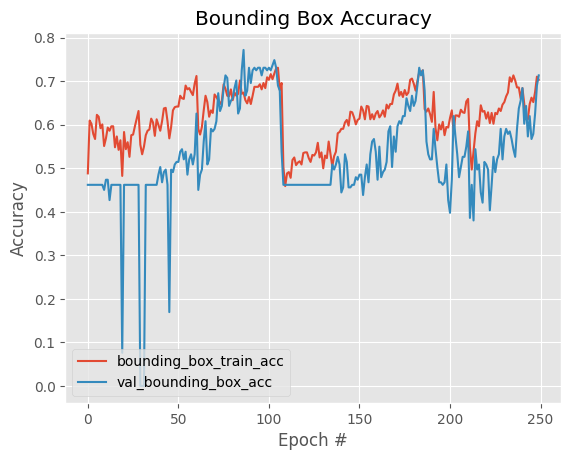

In [ ]:
# Create a new figure for the bounding box accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["bounding_box_accuracy"],
    label="bounding_box_train_acc")
plt.plot(N, H.history["val_bounding_box_accuracy"],
    label="val_bounding_box_acc")
plt.title("Bounding Box Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")

# Save the bounding box accuracy plot
# plotPathBoundingBox = os.path.sep.join([PLOTS_PATH, "accsVGG16_bounding_box.png"])
# plt.savefig(plotPathBoundingBox)

In [ ]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model
import numpy as np
import mimetypes
import argparse
import imutils
import pickle
import cv2
import os
from google.colab.patches import cv2_imshow

In [ ]:
# determine the input file type, but assume that we're working with
# single input image/c
filetype = mimetypes.guess_type("/content/drive/MyDrive/dataset/img/401.png")[0]
imagePaths = ["/content/drive/MyDrive/dataset/img/401.png"]
# if the file type is a text file, then we need to process *multiple*
# images
if "text/plain" == filetype:
	# load the image paths in our testing file
	imagePaths = open("/content/drive/MyDrive/dataset/img/401.png".read().strip().split("\n"))

In [ ]:
# load our object detector and label binarizer from disk
print("[INFO] loading object detector...")
model = load_model(MODEL_PATH_MobileNet_V2)
lb = pickle.loads(open(LB_PATH_MobileNet_V2, "rb").read())

[INFO] loading object detector...


1/1 [==============================] - 1s 1s/step


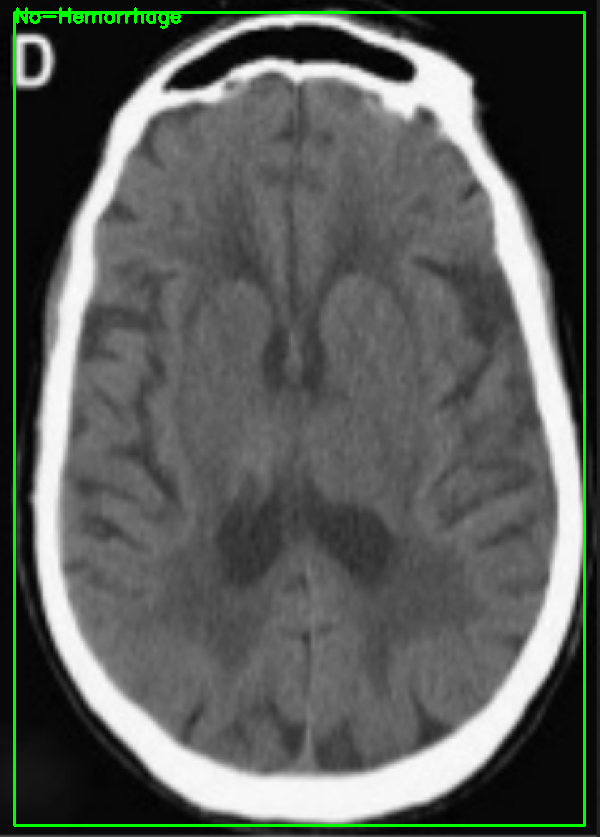

In [ ]:
 # loop over the images that we'll be testing using our bounding box
# regression model
for imagePath in imagePaths:
	# load the input image (in Keras format) from disk and preprocess
	# it, scaling the pixel intensities to the range [0, 1]
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image) / 255.0
	image = np.expand_dims(image, axis=0)
	# predict the bounding box of the object along with the class
	# label
	(boxPreds, labelPreds) = model.predict(image)
	(startX, startY, endX, endY) = boxPreds[0]
	# determine the class label with the largest predicted
	# probability
	i = np.argmax(labelPreds, axis=1)
	label = lb.classes_[i][0]
	# load the input image (in OpenCV format), resize it such that it
	# fits on our screen, and grab its dimensions
	image = cv2.imread(imagePath)
	image = imutils.resize(image, width=600)
	(h, w) = image.shape[:2]
	# scale the predicted bounding box coordinates based on the image
	# dimensions
	startX = int(startX * w)
	startY = int(startY * h)
	endX = int(endX * w)
	endY = int(endY * h)
	# draw the predicted bounding box and class label on the image
	y = startY - 10 if startY - 10 > 10 else startY + 10
	cv2.putText(image, label, (startX, y), cv2.FONT_HERSHEY_SIMPLEX,
		0.65, (0, 255, 0), 2)
	cv2.rectangle(image, (startX, startY), (endX, endY),
		(0, 255, 0), 2)
	# show the output image
	cv2_imshow(image)
	cv2.waitKey(0)

Mạng Iception V3


In [ ]:
# import the necessary packages
import os
# define the base path to the input dataset and then use it to derive
# the path to the images directory and annotation CSV file
BASE_PATH = "/content/drive/MyDrive/dataset"
IMAGES_PATH = os.path.sep.join([BASE_PATH, "img"])
ANNOTS_PATH = os.path.sep.join([BASE_PATH, "labels_head_ct_lb.csv"])

In [ ]:
# Define the path to the base output directory
BASE_OUTPUT = "/content/drive/MyDrive/dataset/output"

# Define the path to the output model, label binarizer, plots output directory, and testing image paths
MODEL_PATH_InceptionV3 = os.path.sep.join([BASE_OUTPUT, "InceptionV3_detector.h5"])
LB_PATH_InceptionV3 = os.path.sep.join([BASE_OUTPUT, "InceptionV3_lb.pickle"])
PLOTS_PATH_InceptionV3 = os.path.sep.join([BASE_OUTPUT, "InceptionV3_plots"])
TEST_PATHS_InceptionV3 = os.path.sep.join([BASE_OUTPUT, "InceptionV3_test_images.txt"])

In [ ]:
from keras.applications import InceptionV3
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.layers import Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import pandas as pd
import csv
import pickle

In [ ]:

# initialize our initial learning rate, number of epochs to train
# for, and the batch size
INIT_LR = 1e-4
NUM_EPOCHS = 250
BATCH_SIZE = 16

In [ ]:
# load the contents of the CSV annotations file
print("[INFO] loading dataset...")
rows = open(ANNOTS_PATH).read().strip().split("\n")

# create a DataFrame from the rows
df = pd.DataFrame([row.split(",") for row in rows], columns=["filename", "startX", "startY", "endX", "endY", "label"])


# initialize the list of data (images), our target output predictions
# (bounding box coordinates), along with the filenames and labels
# of the individual images
data = []
targets = []
filenames = []
labels = []

with open(ANNOTS_PATH, 'r') as file:
    reader = csv.reader(file)
    next(reader)  # Skip the header row
    for row in reader:
        filename, startX, startY, endX, endY, label = row

        # Derive the path to the input image
        imagePath = os.path.join(IMAGES_PATH, filename)

        # Load the image (in OpenCV format)
        image = cv2.imread(imagePath)

        if image is None:
            print(f"Error loading image: {imagePath}")
            continue

        (h, w) = image.shape[:2]

        # Scale the bounding box coordinates relative to the spatial
        # dimensions of the input image
        startX = float(startX) / w
        startY = float(startY) / h
        endX = float(endX) / w
        endY = float(endY) / h

        # Load the image and preprocess it
        image = load_img(imagePath, target_size=(224, 224))
        image = img_to_array(image)

        # Update the lists of data, targets, filenames, and labels
        data.append(image)
        targets.append((startX, startY, endX, endY))
        filenames.append(filename)
        labels.append(label)

[INFO] loading dataset...


In [ ]:
bboxes = np.array(targets)
imagePaths = np.array(filenames)

In [ ]:
# convert the data, class labels, bounding boxes, and image paths to
# NumPy arrays, scaling the input pixel intensities from the range
# [0, 255] to [0, 1]
data = np.array(data, dtype="float32") / 255.0
labels = np.array(labels)
bboxes = np.array(bboxes, dtype="float32")
imagePaths = np.array(imagePaths)
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
# only there are only two labels in the dataset, then we need to use
# Keras/TensorFlow's utility function as well
if len(lb.classes_) == 2:
	labels = to_categorical(labels)

In [ ]:
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
split = train_test_split(data, labels, bboxes, imagePaths,
	test_size=0.20, random_state=42)
# unpack the data split
(trainImages, testImages) = split[:2]
(trainLabels, testLabels) = split[2:4]
(trainBBoxes, testBBoxes) = split[4:6]
(trainPaths, testPaths) = split[6:]
# write the testing image paths to disk so that we can use then
# when evaluating/testing our object detector
print("[INFO] saving testing image paths...")
f = open(TEST_PATHS_InceptionV3, "w")
f.write("\n".join(testPaths))
f.close()

[INFO] saving testing image paths...


In [ ]:
# load the InceptionV3 V2 network, ensuring the head FC layers are left off
InceptionV3 = InceptionV3(weights="imagenet", include_top=False,
                    input_tensor=Input(shape=(224, 224, 3)))

# freeze all InceptionV3 layers so they will not be updated during the training process
InceptionV3.trainable = True

# flatten the max-pooling output of TInceptionV3
flatten = InceptionV3.output
flatten = Flatten()(flatten)

87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
# construct a fully-connected layer header to output the predicted bounding box coordinates
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid", name="bounding_box")(bboxHead)

# construct a second fully-connected layer head, this one to predict the class label
softmaxHead = Dense(512, activation="relu")(flatten)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(512, activation="relu")(softmaxHead)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(len(lb.classes_), activation="softmax", name="class_label")(softmaxHead)

# put together our model which accepts an input image and then outputs bounding box coordinates and a class label
model = Model(inputs=InceptionV3.input, outputs=(bboxHead, softmaxHead))

In [ ]:
# define a dictionary to set the loss methods -- categorical
# cross-entropy for the class label head and mean absolute error
# for the bounding box head
losses = {
	"class_label": "categorical_crossentropy",
	"bounding_box": "mean_squared_error",
}
# define a dictionary that specifies the weights per loss (both the
# class label and bounding box outputs will receive equal weight)
lossWeights = {
	"class_label": 1.0,
	"bounding_box": 1.0
}
# initialize the optimizer, compile the model, and show the model
# summary
opt = Adam(lr=INIT_LR)
model.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=lossWeights)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['batch_normalization[0][0

In [ ]:
# construct a dictionary for our target training outputs
trainTargets = {
	"class_label": trainLabels,
	"bounding_box": trainBBoxes
}
# construct a second dictionary, this one for our target testing
# outputs
testTargets = {
	"class_label": testLabels,
	"bounding_box": testBBoxes
}

In [ ]:
import time
start_time = time.time()
 # train the network for bounding box regression and class label
# prediction
print("[INFO] training model...")
H = model.fit(
	trainImages, trainTargets,
	validation_data=(testImages, testTargets),
	batch_size=BATCH_SIZE,
	epochs=NUM_EPOCHS,
	verbose=1)
# Record the end time
end_time = time.time()
# Calculate the training time
training_time = end_time - start_time
# serialize the model to disk
print("[INFO] saving object detector model...")
model.save(MODEL_PATH_InceptionV3, save_format="h5")
# serialize the label binarizer to disk
print("[INFO] saving label binarizer...")
f = open(LB_PATH_InceptionV3, "wb")
f.write(pickle.dumps(lb))
f.close()

[INFO] training model...
Epoch 1/250
43/43 [==============================] - 430s 9s/step - loss: 2.8101 - bounding_box_loss: 0.0767 - class_label_loss: 2.7333 - bounding_box_accuracy: 0.4664 - class_label_accuracy: 0.6316 - val_loss: 276.5225 - val_bounding_box_loss: 0.0917 - val_class_label_loss: 276.4307 - val_bounding_box_accuracy: 0.4620 - val_class_label_accuracy: 0.4269
Epoch 2/250
43/43 [==============================] - 380s 9s/step - loss: 0.4281 - bounding_box_loss: 0.0394 - class_label_loss: 0.3887 - bounding_box_accuracy: 0.5497 - class_label_accuracy: 0.9050 - val_loss: 12.9771 - val_bounding_box_loss: 0.1557 - val_class_label_loss: 12.8214 - val_bounding_box_accuracy: 0.5380 - val_class_label_accuracy: 0.5556
Epoch 3/250
 7/43 [===>..........................] - ETA: 5:05 - loss: 0.2074 - bounding_box_loss: 0.0174 - class_label_loss: 0.1900 - bounding_box_accuracy: 0.6250 - class_label_accuracy: 0.9286

KeyboardInterrupt: ignored

In [ ]:
# Calculate average training and validation loss and accuracy
avg_train_loss = np.mean(H.history["loss"])
avg_train_accuracy = np.mean(H.history["class_label_accuracy"])
avg_val_loss = np.mean(H.history["val_loss"])
avg_val_accuracy = np.mean(H.history["val_class_label_accuracy"])

# Print average values
print("\n[INFO] Average Training Loss:", avg_train_loss)
print("[INFO] Average Training Accuracy:", avg_train_accuracy)
print("\n[INFO] Average Validation Loss:", avg_val_loss)
print("[INFO] Average Validation Accuracy:", avg_val_accuracy)
print("\n[INFO] Training Time:", training_time, "seconds")


In [ ]:
# plot the total loss, label loss, and bounding box loss
lossNames = ["loss", "class_label_loss", "bounding_box_loss"]
N = np.arange(0, NUM_EPOCHS)
plt.style.use("ggplot")
(fig, ax) = plt.subplots(3, 1, figsize=(13, 13))
# loop over the loss names
for (i, l) in enumerate(lossNames):
	# plot the loss for both the training and validation data
	title = "Loss for {}".format(l) if l != "loss" else "Total loss"
	ax[i].set_title(title)
	ax[i].set_xlabel("Epoch #")
	ax[i].set_ylabel("Loss")
	ax[i].plot(N, H.history[l], label=l)
	ax[i].plot(N, H.history["val_" + l], label="val_" + l)
	ax[i].legend()
# save the losses figure and create a new figure for the accuracies
# plt.tight_layout()
# PLOTS_PATH = os.path.dirname(PLOTS_PATH_MobileNet_V2)
# plotPath = os.path.sep.join([PLOTS_PATH_MobileNet_V2, "lossesMobileNetV2.png"])
# plt.savefig(plotPath)

In [ ]:
# create a new figure for the accuracies
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["class_label_accuracy"],
	label="class_label_train_acc")
plt.plot(N, H.history["val_class_label_accuracy"],
	label="val_class_label_acc")
plt.title("Class Label Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
# save the accuracies plot
# plotPath = os.path.sep.join([PLOTS_PATH_MobileNet_V2, "accsMobinetV2.png"])
# plt.savefig(plotPath)

In [ ]:
# Create a new figure for the bounding box accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["bounding_box_accuracy"],
    label="bounding_box_train_acc")
plt.plot(N, H.history["val_bounding_box_accuracy"],
    label="val_bounding_box_acc")
plt.title("Bounding Box Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")

# Save the bounding box accuracy plot
# plotPathBoundingBox = os.path.sep.join([PLOTS_PATH, "accsVGG16_bounding_box.png"])
# plt.savefig(plotPathBoundingBox)

In [ ]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model
import numpy as np
import mimetypes
import argparse
import imutils
import pickle
import cv2
import os
from google.colab.patches import cv2_imshow

In [ ]:
# determine the input file type, but assume that we're working with
# single input image/c
filetype = mimetypes.guess_type("/content/drive/MyDrive/dataset/img/001.png")[0]
imagePaths = ["/content/drive/MyDrive/dataset/img/001.png"]
# if the file type is a text file, then we need to process *multiple*
# images
if "text/plain" == filetype:
	# load the image paths in our testing file
	imagePaths = open("/content/drive/MyDrive/dataset/img/001.png".read().strip().split("\n"))

In [ ]:
# load our object detector and label binarizer from disk
print("[INFO] loading object detector...")
model = load_model(MODEL_PATH_InceptionV3)
lb = pickle.loads(open(LB_PATH_InceptionV3, "rb").read())

In [ ]:
 # loop over the images that we'll be testing using our bounding box
# regression model
for imagePath in imagePaths:
	# load the input image (in Keras format) from disk and preprocess
	# it, scaling the pixel intensities to the range [0, 1]
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image) / 255.0
	image = np.expand_dims(image, axis=0)
	# predict the bounding box of the object along with the class
	# label
	(boxPreds, labelPreds) = model.predict(image)
	(startX, startY, endX, endY) = boxPreds[0]
	# determine the class label with the largest predicted
	# probability
	i = np.argmax(labelPreds, axis=1)
	label = lb.classes_[i][0]
	# load the input image (in OpenCV format), resize it such that it
	# fits on our screen, and grab its dimensions
	image = cv2.imread(imagePath)
	image = imutils.resize(image, width=600)
	(h, w) = image.shape[:2]
	# scale the predicted bounding box coordinates based on the image
	# dimensions
	startX = int(startX * w)
	startY = int(startY * h)
	endX = int(endX * w)
	endY = int(endY * h)
	# draw the predicted bounding box and class label on the image
	y = startY - 10 if startY - 10 > 10 else startY + 10
	cv2.putText(image, label, (startX, y), cv2.FONT_HERSHEY_SIMPLEX,
		0.65, (0, 255, 0), 2)
	cv2.rectangle(image, (startX, startY), (endX, endY),
		(0, 255, 0), 2)
	# show the output image
	cv2_imshow(image)
	cv2.waitKey(0)